In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.vision.all import *
import sklearn.metrics as skm
from tqdm.notebook import tqdm

In [3]:
from utils import *

In [4]:
conf = {
    'bs':180,
    'emb_size':256,
    'arch':resnet34,
    'split':0
}

In [5]:
PATH = Path('../input/shopee-product-matching')
model_file  = '../input/resnet-model/resnet34.pth'
if not PATH.is_dir():
    PATH = Path('/home/slex/data/shopee')
    model_file ='models/resnet34.pth'

In [24]:
TAKE_PAIRS = 4

In [7]:
def hash_label(x):
    x = (13*x)%10000
    return x // 2000
train_df = pd.read_csv(PATH/'train.csv')
train_df['split']=train_df.label_group.apply(hash_label)
train_df['is_valid'] = train_df.split==conf['split']

def get_img_file(row):
    img =row.image
    fn  = PATH/'train_images'/img
    if not fn.is_file():
        fn = PATH/'test_images'/img
    return fn

data_block = DataBlock(blocks = (ImageBlock(), CategoryBlock(vocab=train_df.label_group.to_list())),
                 splitter=ColSplitter(),
                 get_y=ColReader('label_group'),
                 get_x=get_img_file,
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75),
                 )
dls = data_block.dataloaders(train_df, bs=conf['bs'])

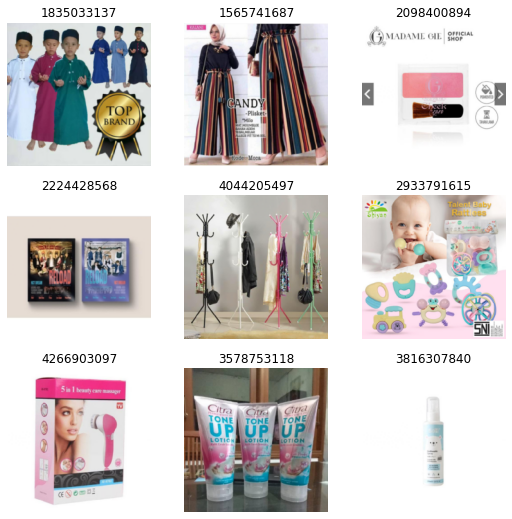

In [8]:
dls.valid.show_batch()

In [9]:
learn = cnn_learner(dls,conf['arch'], pretrained=False,path='../input', model_dir='resnet-model')
state = torch.load(model_file)['model']
learn.model.load_state_dict(state, strict=True)

<All keys matched successfully>

In [10]:
def embs_from_resnet(model, dl):
    model_stem =list(model.children())[0].eval()
    pipeline = nn.Sequential(model_stem, AdaptiveConcatPool2d(), Flatten())
    all_embs = []
    all_ys=[]
    for batch in tqdm(dl):
        if len(batch) ==2:
            bx,by=batch
        else:
            bx,=batch
            by=torch.zeros(1)
        with torch.no_grad():
            embs = pipeline(bx)
            all_embs.append(embs.half())
        all_ys.append(by)
    all_embs = F.normalize(torch.cat(all_embs))
    return all_embs, torch.cat(all_ys)

In [11]:
def do_chunk(embs):
    step = 10000
    for chunk_start in range(0, embs.shape[0], step):
        chunk_end = min(chunk_start+step, len(embs))
        yield embs[chunk_start:chunk_end]

In [12]:
def get_nearest(embs, emb_chunks):
    K = min(50, len(embs))
    distances = []
    indices = []
    for chunk in emb_chunks:
        sim = embs @ chunk.T
        top_vals, top_inds = sim.topk(K, dim=0)
        distances.append(top_vals.T)
        indices.append(top_inds.T)
    return torch.cat(distances), torch.cat(indices)

## Check on validation set

In [13]:
# valid_embs, valid_ys = embs_from_resnet(learn.model.cuda(), dls.valid)

# dists, inds = get_nearest(valid_embs, do_chunk(valid_embs))

# pairs = sorted_pairs(dists, inds)[:len(valid_embs)*10]
# targets = [torch.where(valid_ys==valid_ys[i])[0].tolist() for i in range(len(valid_ys))]

# _=build_from_pairs(pairs, targets)

## Run on the test set

In [14]:
test_df = pd.read_csv(PATH/'test.csv')


In [15]:
# fake_test_df = train_df[['posting_id', 'image', 'image_phash', 'title']].copy()
# #fake_test_df = pd.concat([fake_test_df, fake_test_df])
# test_df = fake_test_df

In [16]:
test_dl = dls.test_dl(test_df)

In [17]:
embs, _ = embs_from_resnet(learn.model.cuda(), test_dl)

  0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
dists, inds = get_nearest(embs, do_chunk(embs))

In [19]:
pairs = sorted_pairs(dists, inds)[:int(len(embs)*TAKE_PAIRS)]

In [20]:
groups = [[] for _ in range(len(test_df))]
for x,y,v in pairs:
    groups[x].append(y)

In [22]:
matches = [' '.join(test_df.iloc[g].posting_id.to_list()) for g in groups]
test_df['matches'] = matches

test_df[['posting_id','matches']].to_csv('submission.csv',index=False)

In [23]:
pd.read_csv('submission.csv').head()

,posting_id,matches
0,test_2255846744,test_2255846744 test_4015706929 test_3588702337
1,test_3588702337,test_3588702337 test_4015706929 test_2255846744
2,test_4015706929,test_4015706929 test_3588702337 test_2255846744
